In [1]:
from proglearn.progressive_learner import ClassificationProgressiveLearner
from proglearn.transformers import TreeClassificationTransformer
from proglearn.voters import TreeClassificationVoter
from proglearn.deciders import SimpleArgmaxAverage

from sklearn.tree import DecisionTreeClassifier
from joblib import Parallel, delayed
from collections import defaultdict
import joblib
from sklearn.utils.fixes import _joblib_parallel_args
import threading
from sklearn.ensemble._base import _partition_estimators
from sklearn.utils.validation import check_is_fitted

import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.validation import check_X_y, check_array


from hyppo.tools import multimodal_independence, indep_sim, rot_ksamp
from hyppo.tools import SIMULATIONS
from hyppo.ksample._utils import k_sample_transform
from tqdm import tqdm
from hyppo.tools import * 

from scipy.stats import entropy, multivariate_normal
from math import ceil


import matplotlib.pyplot as plt

2023-01-30 18:58:41.744987: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 18:58:42.640688: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-30 18:58:42.640780: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-30 18:58:42.640790: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [2]:
class UncertaintyForest:
    """
    A class used to represent an Uncertainty Forest.
    Parameters
    ----------
    n_estimators : int, default=100
        The number of trees in the UncertaintyForest
    kappa : float, default=np.inf
        The coefficient for finite sample correction. If set to the default
        value, finite sample correction is not performed.
    max_depth : int, default=None
        The maximum depth of a tree in the UncertaintyForest.
    tree_construction_proportion : float, default=0.5
        The proportions of the input data set aside to train each decision
        tree. The remainder of the data is used to fill in voting posteriors.
    max_features : {"auto", "sqrt", "log2"}, int or float, default="auto"
        The number of features to consider when looking for the best split:
        - If int, then consider `max_features` features at each split.
        - If float, then `max_features` is a fraction and
          `round(max_features * n_features)` features are considered at each
          split.
        - If "auto", then `max_features=sqrt(n_features)`.
        - If "sqrt", then `max_features=sqrt(n_features)` (same as "auto").
        - If "log2", then `max_features=log2(n_features)`.
        - If None, then `max_features=n_features`.
        Note: the search for a split does not stop until at least one
        valid partition of the node samples is found, even if it requires to
        effectively inspect more than ``max_features`` features.
    poisson_sampler : boolean, default=False
        To match the GRF theory [#1grf]_, if True, the number of features
        considered at each tree are drawn from a poisson distribution with
        mean equal to `max_features`.
    n_jobs : int, default=None
        The number of jobs to run in parallel. ``-1`` means use all
        processors. None equates to 1.
    max_samples : int or float, default=None
        The number of samples to draw from X (without replacement) to train
        each tree.
        - If None, then draw `X.shape[0]` samples.
        - If int, then draw `max_samples` samples.
        - If float, then draw `max_samples * X.shape[0]` samples. Thus,
          `max_samples` should be in the interval `(0, 1)`.
        Note: The number of samples used to learn the tree will be further
        reduced per the `tree_construction_proportion` value.
    honest_prior : {"ignore", "uniform", "empirical"}, default="ignore"
        Method for dealing with empty leaves during evaluation of a test
        sample. If "ignore", trees in which the leaf is empty are not used in
        the prediction. If "uniform", the prior tree posterior is 1/(number of
        classes). If "empirical", the prior tree posterior is the relative
        class frequency in the voting subsample. If all tree leaves are empty,
        "ignore" will use the empirical prior and the others will use their
        respective priors.
    tree_kwargs : dict, default={}
        Named arguments to be passed to each
        sklearn.tree.DecisionTreeClassifier tree used in the construction
        of the forest in addition to the above parameters.
    Attributes
    ----------
    transformers_ : list of sklearn.tree.DecisionTreeClassifier
        The collection of fitted trees.
    voters_ : list of proglearn.voter.TreeClassificationVoter
        The collection of honest voters for leaves in matching trees in
        `self.estimators_` at the same index.
    n_features_ : int
        The number of features when `fit` is performed.
    tree_kwargs_ : dict
        Full set of keyword arguments passed to the Forest transformer.
    References
    ----------
    .. [#1grf] Athey, Susan, Julie Tibshirani and Stefan Wager.
        "Generalized Random Forests", Annals of Statistics, 2019.
    """

    def __init__(
        self,
        n_estimators=100,
        kappa=np.inf,
        max_depth=None,
        tree_construction_proportion=0.63,
        max_features="auto",
        poisson_sampler=False,
        max_samples=None,
        n_jobs=None,
        honest_prior="ignore",
        weighted_trees=False,
        min_samples_leaf=1,
        min_samples_split=2,
        min_impurity_decrease=0.0,
    ):
        self.n_estimators = n_estimators
        self.kappa = kappa
        self.max_depth = max_depth
        self.tree_construction_proportion = tree_construction_proportion
        self.max_features = max_features
        self.poisson_sampler = poisson_sampler
        self.max_samples = max_samples
        self.n_jobs = n_jobs
        self.honest_prior = honest_prior
        self.verbose = 0
        self.weighted_trees = weighted_trees
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        self.min_impurity_decrease = min_impurity_decrease
        

    def fit(self, X, y):
        """
        fits forest to data X with labels y
        Parameters
        ----------
        X : array of shape [n_samples, n_features]
            The data that will be trained on
        y : array of shape [n_samples]
            The label for cluster membership of the given data
        Returns
        -------
        self : UncertaintyForest
            The object itself.
        """
        X, y = check_X_y(X, y)

        self.n_samples_, self.n_features_ = X.shape
        self.n_classes_ = len(np.unique(y))
        self.empirical_prior_ = np.bincount(y, minlength=self.n_classes_) / len(y)

        self.transformers_ = [
            DecisionTreeClassifier(
                max_features = self.max_features,
                max_depth = self.max_depth,
                min_samples_leaf = self.min_samples_leaf,
                min_samples_split = self.min_samples_split,
                min_impurity_decrease = self.min_impurity_decrease,
                )
            for _ in range(self.n_estimators)
        ]

        # Source https://github.com/scikit-learn/scikit-learn/blob/95119c13a/sklearn/ensemble/_forest.py#L387
        self.transformers_, self.transformer_indices_ = list(zip(
            *Parallel(n_jobs=self.n_jobs, verbose=self.verbose, **_joblib_parallel_args(prefer="threads"))(
                delayed(_parallel_build_trees)(
                    X, y, tree, self.n_samples_, self.n_classes_,
                    self.honest_prior, self.tree_construction_proportion,
                    self.kappa, self.weighted_trees)
                for tree in self.transformers_)
                ))

        return self

    def predict_proba(self, X):
        """
        estimates class posteriors for each example in input data X.
        Parameters
        ----------
        X : array of shape [n_samples, n_features]
            The data whose posteriors we are estimating.
        Returns
        -------
        y_proba_hat : ndarray of shape [n_samples, n_classes]
            posteriors per example
        """
        X = self._validate_X_predict(X)
        n_jobs, _, _ = _partition_estimators(self.n_estimators, self.n_jobs)

        # avoid storing the output of every estimator by summing them here
        posteriors = np.zeros((X.shape[0], self.n_classes_), dtype=np.float64)
        lock = threading.Lock()

        Parallel(n_jobs=n_jobs, verbose=self.verbose, **_joblib_parallel_args(require="sharedmem"))(
            delayed(_accumulate_prediction)(tree.tree_.predict, X, posteriors, lock, None, self.weighted_trees)
            for tree in self.transformers_)

        # Normalize to unit length, due to prior weighting
        zero_mask = posteriors.sum(1) == 0
        posteriors[~zero_mask] /= posteriors[~zero_mask].sum(1, keepdims=True)
        posteriors[zero_mask] = self.empirical_prior_

        return posteriors

    def _validate_X_predict(self, X):
        """
        From sklearn
        Validate X whenever one tries to predict, apply, predict_proba."""
        check_is_fitted(self)

        return self.transformers_[0]._validate_X_predict(X, check_input=True)

    def predict(self, X):
        """
        predicts class labels for each example in input data X.
        Parameters
        ----------
        X : array of shape [n_samples, n_features]
            The data on which we are performing inference.
        Returns
        -------
        y_hat : ndarray of shape [n_samples]
            predicted class label per example
        """
        return self.predict_proba(X).argmax(1)

    def predict_proba_honest(self, X, voters=True):
        """
        Returns predicted posteriors of the training data, excluding trees a
        sample was used in construction of.
        Parameters
        ----------
        X : array of shape [n_samples, n_features]
            The data on which the forest was fit to.
        Returns
        -------
        y_proba_hat : ndarray of shape [n_samples, n_classes]
            posteriors per example
        """
        X = self._validate_X_predict(X)
        n_jobs, _, _ = _partition_estimators(self.n_estimators, self.n_jobs)

        # avoid storing the output of every estimator by summing them here
        posteriors = np.zeros((X.shape[0], self.n_classes_), dtype=np.float64)
        lock = threading.Lock()

        if voters:
            Parallel(n_jobs=n_jobs, verbose=self.verbose, **_joblib_parallel_args(require="sharedmem"))(
                delayed(_accumulate_prediction)(tree.tree_.predict, X, posteriors, lock, honest_indices)
                for tree, honest_indices in zip(self.transformers_, self.voter_indices_))
        else:
            Parallel(n_jobs=n_jobs, verbose=self.verbose, **_joblib_parallel_args(require="sharedmem"))(
                delayed(_accumulate_prediction)(tree.tree_.predict, X, posteriors, lock, indices)
                for tree, indices in zip(self.transformers_, self.transformer_indices_))

        # Normalize to unit length, due to prior weighting
        zero_mask = posteriors.sum(1) == 0
        posteriors[~zero_mask] /= posteriors[~zero_mask].sum(1, keepdims=True)
        posteriors[zero_mask] = self.empirical_prior_

        return posteriors


    @property
    def voter_indices_(self):
        if not hasattr(self, "transformer_indices_"):
            raise AttributeError("Model has not been fitted. Please fit first.")
        return [
            np.setdiff1d(np.arange(self.n_samples_), transformer_indices)
            for transformer_indices in self.transformer_indices_]


def _parallel_build_trees(
    X, y, tree, n_samples_, n_classes_,
    honest_prior, tree_construction_proportion,
    kappa, weighted_trees):
        # https://github.com/scikit-learn/scikit-learn/blob/95119c13a/sklearn/ensemble/_forest.py#L140
        """
        Private function used to fit a single tree in parallel."""

        transformer_indices = np.random.choice(
            n_samples_,
            int(tree_construction_proportion * n_samples_),
            replace=False)  # No bootstrapping
        voter_indices = np.setdiff1d(
            np.arange(n_samples_), transformer_indices)

        sample_weight = np.ones((n_samples_,), dtype=np.float64)
        sample_counts = np.bincount(
            transformer_indices, minlength=n_samples_)
        sample_weight *= sample_counts

        #tree = tree.fit(X, y, sample_weight=sample_weight, check_input=False) ### Why using y, rather than X[transformer_indices,:],y[transformer_indices]
        tree = tree.fit(X[transformer_indices,:],y[transformer_indices], sample_weight=sample_weight[transformer_indices], check_input=False)
        
        honest_leaves = tree.apply(X[voter_indices])
        # empirical_prior = np.bincount(
        #     y[voter_indices], minlength=n_classes_)

        # if honest_prior == 'ignore':
        #     posterior_dict = defaultdict(lambda: np.zeros(n_classes_))
        # elif honest_prior == 'empirical':
        #     posterior_dict = defaultdict(lambda: empirical_prior)
        # elif honest_prior == 'uniform':
        #     posterior_dict = defaultdict(lambda: np.ones(n_classes_) / n_classes_)

        tree.tree_.value[:, :, :] = 0 # empirical_prior

        for leaf_id, yval in zip(honest_leaves, y[voter_indices]):
            # posterior_dict[leaf_id][yval] += 1
            tree.tree_.value[leaf_id][0, yval] += 1

        # for leaf_id in np.unique(honest_leaves):
        #     leaf_id_indices = np.where(honest_leaves == leaf_id)[0]
        #     correction = 1 / (kappa * len(leaf_id_indices))
        #     posterior = correction * empirical_prior + \
        #         (1 - correction) * np.bincount(
        #             y[voter_indices[leaf_id_indices]],
        #             minlength=n_classes_) / len(leaf_id_indices)
        #     posterior_dict[leaf_id] = posterior * (len(leaf_id_indices) if weighted_trees else 1)

        return tree, transformer_indices


def _accumulate_prediction(predict, X, out, lock, honest_indices=None, weighted_trees=False):
    """
    See https://github.com/scikit-learn/scikit-learn/blob/95119c13af77c76e150b753485c662b7c52a41a2/sklearn/ensemble/_forest.py#L460
    This is a utility function for joblib's Parallel.
    It can't go locally in ForestClassifier or ForestRegressor, because joblib
    complains that it cannot pickle it when placed there.
    """

    # predict = DecisionTreeClassifier.tree_.predict
    if honest_indices is not None:
        proba = predict(X[honest_indices])
    else:
        proba = predict(X)
    if not weighted_trees:
        zero_mask = proba.sum(1) == 0
        proba[~zero_mask] /= proba[~zero_mask].sum(1, keepdims=True)
    with lock:
        if honest_indices is not None:
            out[honest_indices] += proba
        else:
            out += proba

In [3]:
class UFTest_permute_tree:
    def __init__(self, uf):
        self.name = 'UF'
        self.uf = uf
        self.fit_ = False
        
    def statistic(self, X, y):
        y = y.ravel()
        if not self.fit_:
            self.uf = self.uf.fit(X, y)
            self.y_ = y
#             if hasattr(self, "honest_leaf_indices_"):
#                 assert hasattr(self, "transformer_leaf_indices_")
#                 del self.honest_leaf_indices_
#                 del self.transformer_leaf_indices_
            self.fit_ = True
            H_YX = np.mean(entropy(self.uf.predict_proba(X), base=np.exp(1), axis=1))

        # if not hasattr(self, "honest_leaf_indices_"):
            self.honest_leaf_indices_ = []
            self.transformer_leaf_indices_ = []
            for tree, voter_indices, transformer_indices in zip(self.uf.transformers_, self.uf.voter_indices_, self.uf.transformer_indices_):
                self.honest_leaf_indices_.append(tree.apply(X[voter_indices]))
                self.transformer_leaf_indices_.append(tree.apply(X[transformer_indices]))
        else:
            H_YX = self._refit_apply_oob(X, self.y_) # changed from y to self.y_ as does the permutation internally per tree
            ### y has been permuted

        _, counts = np.unique(y, return_counts=True)
        H_Y = entropy(counts, base=np.exp(1))
        return max(H_Y - H_YX, 0)

    def _refit_apply_oob(self, X, y):
        posteriors = np.zeros((X.shape[0], self.uf.n_classes_), dtype=np.float64)
        # posteriors = np.zeros((X.shape[0], self.uf.n_estimators, self.uf.n_classes_), dtype=np.float64)

        # np.random.shuffle(y)
        for tree, honest_leaf_indices, voter_indices, tranformer_leaf_indices, transformer_indices in zip(
            self.uf.transformers_, self.honest_leaf_indices_, self.uf.voter_indices_, self.transformer_leaf_indices_, self.uf.transformer_indices_):
        # for tree_idx, (honest_leaf_indices, voter_indices) in enumerate(zip(self.honest_leaf_indices_, self.uf.voter_indices_)):
            tree.tree_.value[:, :, :] = 0

            y_voters = y[voter_indices]
            np.random.shuffle(y_voters)
            for leaf_id, yval in zip(honest_leaf_indices, y_voters):
                tree.tree_.value[leaf_id][0, yval] += 1

            leaf_indices = np.hstack((honest_leaf_indices, tranformer_leaf_indices))
            sample_indices = np.hstack((voter_indices, transformer_indices))

            proba = tree.tree_.value[leaf_indices][:, 0, :]
            normalizer = proba.sum(axis=1)[:, np.newaxis]
            normalizer[normalizer == 0.0] = 1.0 # solves divide by 0 error
            proba /= normalizer
            posteriors[sample_indices] += proba

        # Normalize to unit length, due to prior weighting
        zero_mask = posteriors.sum(1) == 0
        posteriors[~zero_mask] /= posteriors[~zero_mask].sum(1, keepdims=True)
        posteriors[zero_mask] = self.uf.empirical_prior_

        return np.mean(entropy(posteriors, base=np.exp(1), axis=1))
    

In [33]:
def _perm_stat(calc_stat,sim,sample_size = 100,dim = 2): 
    
    if hasattr(calc_stat, "fit_"):
        calc_stat.fit_ = False
    
    x, y = rot_ksamp(sim, n=sample_size, p=dim,degree = 90, noise=False)
    #print(np.var(y))
    if np.var(y) == 0:
        observe_stat = 0
        null_dist = 0
    else:
        X, y = k_sample_transform([x, y])
        #print(X.shape)
        y = y.astype(int)

        observe_stat = calc_stat.statistic(X, y)
        # Refit Forests at each permutation
        permy = np.random.permutation(y)
        
        if hasattr(calc_stat, "fit_"):
            calc_stat.fit_ = False
        
        null_dist = calc_stat.statistic(X, permy)
    #print(observe_stat,null_dist)
    
    return observe_stat,null_dist


def estimate_power(calc_stat,sim,sample_size_power = 100 ,dim_power = 2,reps = 1000): 
    alt_dist, null_dist = map(np.float64,
                              zip(*[_perm_stat(calc_stat,sim,sample_size_power,dim_power) for _ in range(reps)]),)
    
    # Obtain power by cutoff
    cutoff = np.sort(null_dist)[ceil(reps * (1 - 0.05))]
    print("cutoff " + str(cutoff))
    empirical_power = (1 + (alt_dist >= cutoff).sum()) / (1 + reps)
    print('power ' + str(empirical_power))
    return empirical_power

In [5]:
POWER_REPS = 1000
#sample_size = 100

test = UFTest_permute_tree(
    uf = UncertaintyForest(
        n_estimators=100,
        tree_construction_proportion=0.8,
        kappa=np.inf,
        # min_samples_leaf=5,
        honest_prior="ignore",
        max_features=1.0,
        n_jobs=-1,
    )
)

simulations = SIMULATIONS.keys()
#simulations = 'linear'

In [6]:
SIMULATIONS.keys()

dict_keys(['linear', 'exponential', 'cubic', 'joint_normal', 'step', 'quadratic', 'w_shaped', 'spiral', 'uncorrelated_bernoulli', 'logarithmic', 'fourth_root', 'sin_four_pi', 'sin_sixteen_pi', 'square', 'two_parabolas', 'circle', 'ellipse', 'diamond', 'multiplicative_noise', 'multimodal_independence'])

In [8]:
power_reps =5
sample_size = range(5,105,5)
POWER = []
for sample_size_i in sample_size:
    print('multimodal_independence',sample_size_i)
            # Calculate the mean power over 5 times
    power= np.mean([estimate_power(test,'multimodal_independence',sample_size_i,1) for _ in range(power_reps)])
    print(power)
    POWER.append(power)
print(POWER)

sample_size = range(5,105,5)
alpha = 0.05*np.ones((len(POWER)))



multimodal_independence 5
cutoff 0.2913741718369504
power 0.04595404595404595
cutoff 0.26135029552120026
power 0.056943056943056944
cutoff 0.253153021769463
power 0.055944055944055944
cutoff 0.24469709695631908
power 0.05094905094905095
cutoff 0.20125288067985359
power 0.07792207792207792
0.05754245754245755
multimodal_independence 10
cutoff 0.1670337810231335
power 0.04895104895104895
cutoff 0.15542616854878621
power 0.05194805194805195
cutoff 0.17381649563828083
power 0.03696303696303696
cutoff 0.16451584903324168
power 0.04995004995004995
cutoff 0.1587479881534941
power 0.04695304695304695
0.04695304695304695
multimodal_independence 15
cutoff 0.14019679439388244
power 0.04495504495504495
cutoff 0.12635146895191107
power 0.058941058941058944
cutoff 0.13173530414659695
power 0.06493506493506493
cutoff 0.13353822426793116
power 0.04795204795204795
cutoff 0.13303406601820122
power 0.04695304695304695
0.05274725274725275
multimodal_independence 20
cutoff 0.11713940496577713
power 0.04995

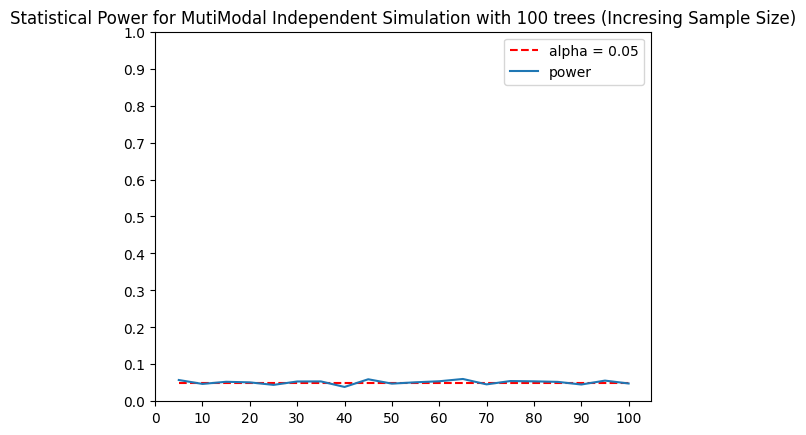

In [10]:
plt.plot (sample_size,alpha,c = 'r',linestyle='--',label = "alpha = 0.05")
plt.plot(sample_size,POWER,label = "power")
plt.yticks(np.arange(0,1.1,0.1))
plt.xticks(np.arange(0,110,10))
plt.title("Statistical Power for MutiModal Independent Simulation with 100 trees (Incresing Sample Size)")
plt.legend()
plt.show()

In [34]:
power_reps = 5
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25, 20))
plt.suptitle(
    "Multivariate Independence Testing (Increasing Dimension)",
    y=0.93,
    va="baseline",
    )

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        count = 5 * i + j
        sim = list(SIMULATIONS.keys())[count]
        if sim in list(SIMULATIONS.keys())[0:8]:
            print(sim)
            POWER = np.load(
                "POWER_1D_multi_cutoff_0130{}.npy".format(sim))
        #sim = ['linear','exponential']
        else: 
            POWER = []
            sample_size = range(5,105,5)
            #dim = range(1,20,1)
            for sample_size_i in sample_size:
                print(sim,sample_size_i)
                # Calculate mean power over 20 times
                power= np.mean([estimate_power(test,sim,sample_size_i,1) for _ in range(power_reps)])
                print(power)
                POWER.append(power)
            np.save(
                "POWER_1D_multi_cutoff_0130{}.npy".format(sim),
                POWER)
           
        #est_power = np.genfromtxt( "{}_{}.csv".format(sim, 'uf'),delimiter=",",)
        col.plot(sample_size,POWER)
        col.set_yticks(np.arange(0,1.1,0.1))
        col.set_xticks(range(0,120,20))
        col.set_title(list(SIMULATIONS.keys())[count])
        #col.yticks(np.arange(0, 1.2, step=0.2))
        #col.show()

linear
exponential
cubic
joint_normal
step
quadratic
w_shaped
spiral
uncorrelated_bernoulli 5
cutoff 0.27080924449338023
power 0.13986013986013987
cutoff 0.2781515987769301
power 0.1048951048951049
cutoff 0.281054282434871
power 0.1038961038961039
cutoff 0.27711201519177964
power 0.13086913086913088
cutoff 0.3030929463749609
power 0.07892107892107893
0.1116883116883117
uncorrelated_bernoulli 10
cutoff 0.18975346446905472
power 0.45454545454545453
cutoff 0.2026999617101966
power 0.3826173826173826
cutoff 0.19033545805549734
power 0.45854145854145856
cutoff 0.19762405021205165
power 0.41058941058941056
cutoff 0.20521606532829795
power 0.3706293706293706
0.41538461538461535
uncorrelated_bernoulli 15
cutoff 0.14760839220636623
power 0.7152847152847153
cutoff 0.13952626500596443
power 0.7792207792207793
cutoff 0.1417928637844611
power 0.7602397602397603
cutoff 0.1420735414060057
power 0.7712287712287712
cutoff 0.13901695135334324
power 0.7952047952047953
0.7642357642357643
uncorrelated_bern

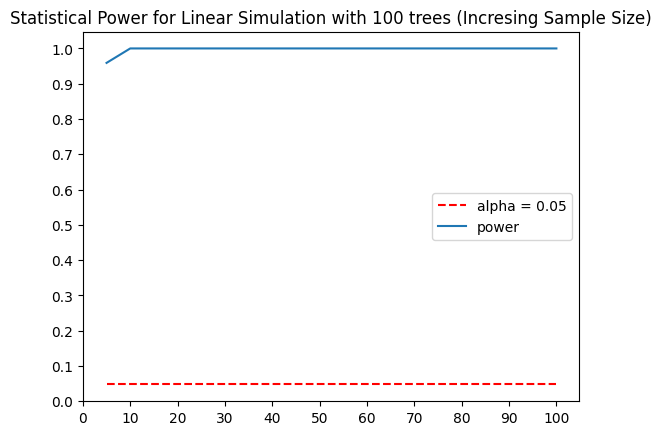

In [13]:
POWER = np.load("POWER_1D_multi_cutoff_0130exponential.npy")
plt.plot (sample_size,alpha,c = 'r',linestyle='--',label = "alpha = 0.05")
plt.plot(sample_size,POWER,label = "power")
plt.yticks(np.arange(0,1.1,0.1))
plt.xticks(np.arange(0,110,10))
plt.title("Statistical Power for Linear Simulation with 100 trees (Incresing Sample Size)")
plt.legend()
plt.show()

In [38]:
SIM_TITLES = [
    "Linear",
    "Exponential",
    "Cubic",
    "Joint Normal",
    "Step",
    "Quadratic",
    "W-Shaped",
    "Spiral",
    "Bernoulli",
    "Logarithmic",
    "Fourth Root",
    "Sine 4\u03C0",
    "Sine 16\u03C0",
    "Square",
    "Two Parabolas",
    "Circle",
    "Ellipse",
    "Diamond",
    "Noise",
    "Independence",
]

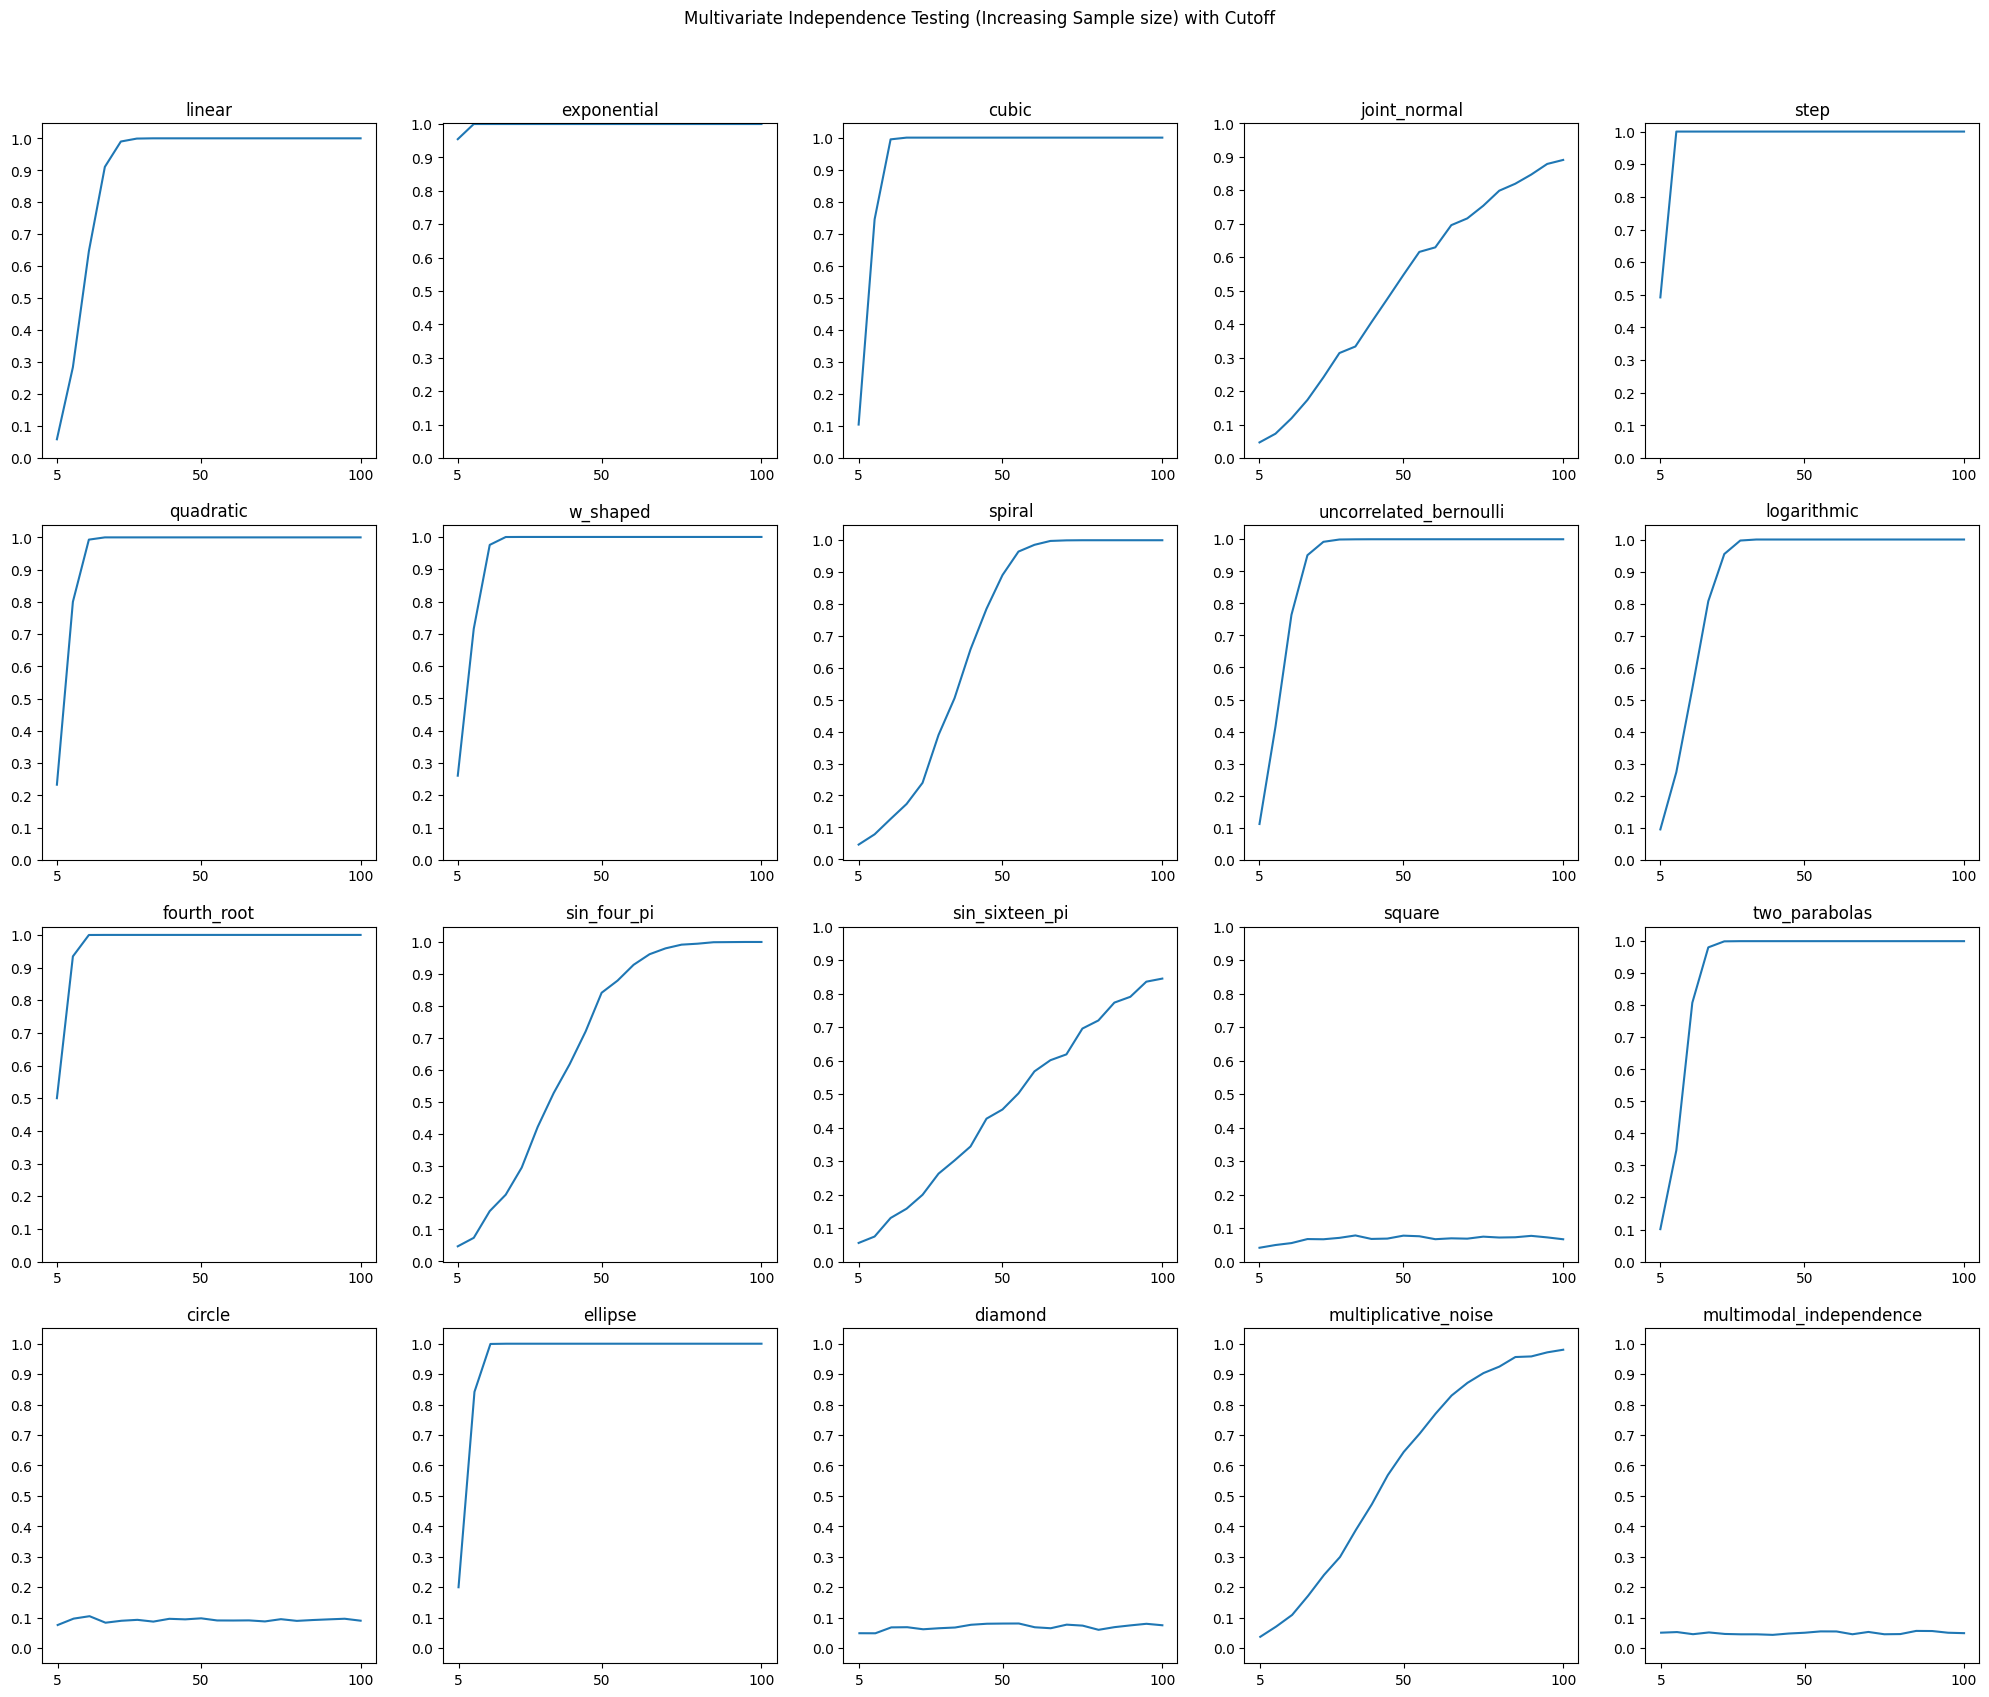

In [41]:
## PLOT FOR Multivariate Independence Testing (Increasing Sample size)

fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25, 20))
plt.suptitle(
    "Multivariate Independence Testing (Increasing Sample size) with Cutoff",
    y=0.93,
    va="baseline",
    )

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        count = 5 * i + j
        sim = list(SIMULATIONS.keys())[count]
        
        sample_size = range(5,105,5)
        #dim = range(1,20,1)
        POWER = np.load(
                "POWER_1D_multi_cutoff_0130{}.npy".format(sim))
        
        col.set_xticks([])
        col.plot(sample_size,POWER)
        if i == 3:
            col.set_xticks(range(0,120,20))
            col.set_ylim(-0.05, 1.05)
            col.set_yticks([])
            if j == 0:
                col.set_yticks([0, 1])
            col.set_title(SIM_TITLES[count])
        #est_power = np.genfromtxt( "{}_{}.csv".format(sim, 'uf'),delimiter=",",)
        
        col.set_yticks(np.arange(0,1.1,0.1))
        col.set_xticks([5,50,100])
        col.set_title(list(SIMULATIONS.keys())[count])
        
        #col.show()